# 2D Fluid Flow for Keyholing Melt Pool

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from jax import jit
from pint import Quantity
from tqdm import tqdm

## Domain
Defined in microns but can be converted to meters using pint

In [2]:
# Domain Lengths
lx = Quantity(100, "microns")
ly = Quantity(100, "microns")
print(f"lx: {lx} ({lx.to('m')}), ly: {ly} ({ly.to('m')})")

# Grid Spacings
dx = dy = Quantity(1, "micron")
print(f"dx: {dx} ({dx.to('m')}), dy: {dy} ({dy.to('m')})")

# Number of points
Nx, Ny = int(lx/dx), int(ly/dy)
print(f"Nx: {Nx}, Ny: {Ny}")

# Grid
x = jnp.linspace(0, lx.magnitude, Nx+1) # start = 0, stop = 100, nums = 101
y = jnp.linspace(0, ly.magnitude, Ny+1)
print(f"x: {x}, y: {y}")

lx: 100 micron (9.999999999999999e-05 meter), ly: 100 micron (9.999999999999999e-05 meter)
dx: 1 micron (1e-06 meter), dy: 1 micron (1e-06 meter)
Nx: 100, Ny: 100
x: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100.], y: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  

## $\omega$ - [Vorticity](https://en.wikipedia.org/wiki/Vorticity) (for 2D flow)
$$\omega = \nabla \times \textbf{v} = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}$$

In [3]:
# Vorticity (initialized as zeros)
omega = jnp.zeros((Nx + 1, Ny + 1))
print(f"omega: {omega}")

omega: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


transport equation:
$$\frac{\partial \omega}{\partial t} + u \cdot \nabla \omega = \nu \nabla^2 \omega$$

discrete time update:
$$\omega_{\text{new}} = \omega + \Delta t \left(-u \cdot \nabla \omega + \nu \nabla^2 \omega\right)$$

$$\omega^{n+1}_{i,j} = \omega^n_{i,j} + \Delta t \left[\nu \nabla^2 \omega - u \cdot \nabla \omega\right]^n_{i,j}$$

terms:
$$\text{conv} = u \nabla\omega$$
$$\text{diff} = \nu\nabla^2\omega$$


$$\omega^{n+1}_{i,j} = \omega^n_{i,j} + \Delta t \left[\text{diff} - \text{conv}\right]^n_{i,j}$$


In [4]:
def update_vorticity(omega, u, v, nu, dx, dy, dt):
    omega_new = jnp.zeros_like(omega)
    
    for i in range(1, Nx):
        for j in range(1, Ny):
            # convection
            domegadx = (omega[i+1,j] - omega[i-1,j]) / (2*dx)
            domegady = (omega[i,j+1] - omega[i,j-1]) / (2*dy)
            conv = u[i,j]*domegadx + v[i,j]*domegady
            
            # diffusion
            d2omegadx2 = (omega[i+1,j] - 2*omega[i,j] + omega[i-1,j]) / dx**2
            d2omegady2 = (omega[i,j+1] - 2*omega[i,j] + omega[i,j-1]) / dy**2
            diff = nu * (d2omegadx2 + d2omegady2)
            
            # time step
            omega_new = omega_new.at[i,j].set(omega[i,j] + dt*(-conv + diff))
    
    return omega_new

### Boundary conditions

No slip boundary conditions ($u = v = 0$) at walls

In [5]:
def apply_vorticity_boundary_conditions(omega, psi, dx, dy):
    """
    No-slip boundary conditions 
    """

    # Bottom wall (j=0): u=0, v=0
    omega = omega.at[:, 0].set(-2*psi[:, 1] / dy**2)
    
    # Top wall (j=Ny): u=0, v=0
    omega = omega.at[:, -1].set(-2*psi[:, -2] / dy**2)
    
    # Left wall (i=0): u=0, v=0
    omega = omega.at[0, :].set(-2*psi[1, :] / dx**2)
    
    # Right wall (i=Nx): u=0, v=0
    omega = omega.at[-1, :].set(-2*psi[-2, :] / dx**2)
    
    return omega

## $\psi$ - 2D Flow
$$u = \frac{\partial \psi}{\partial y},\;v = \frac{-\partial \psi}{\partial x}$$

In [6]:
# Flow
psi = jnp.zeros((Nx + 1, Ny + 1))
print(f"psi: {psi}")

psi: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Boundary Conditions
No flow through boundaries ($\psi = 0$) on all walls

In [7]:
def apply_psi_boundary_conditions(psi):
    """
    No flow through boundaries
    """
    
    psi = psi.at[:, 0].set(0.0)   # Bottom
    psi = psi.at[:, -1].set(0.0)  # Top
    psi = psi.at[0, :].set(0.0)   # Left
    psi = psi.at[-1, :].set(0.0)  # Right
    
    return psi

## Kinematic Viscosity

In [8]:
nu = Quantity(1e-6, "m^2/s") # Kinematic viscosity
print(f"nu (kinematic viscosity): {nu}")

nu (kinematic viscosity): 1e-06 meter ** 2 / second


## [Poisson Equation](https://en.wikipedia.org/wiki/Poisson's_equation)
$$\nabla^2\psi = -\omega$$

$$\omega = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y} = \frac{-\partial^2 \psi}{\partial x^2} - \frac{\partial^2 \psi}{\partial y^2} = -\nabla^2\psi$$

Simplify
$$\omega = \frac{-\partial^2 \psi}{\partial x^2} - \frac{\partial^2 \psi}{\partial y^2}$$

Discretize (Gauss-Seidel)
$$\frac{\psi_{i+1,j} - 2\psi_{i,j} + \psi_{i-1,j}}{dx^2} + \frac{\psi_{i,j+1} - 2\psi_{i,j} + \psi_{i,j-1}}{dy^2} = -\omega_{i,j}$$

Multiply by $dx^2 dy^2$:
$$dy^2(\psi_{i+1,j} + \psi_{i-1,j}) + dx^2(\psi_{i,j+1} + \psi_{i,j-1}) - 2(dx^2 + dy^2)\psi_{i,j} = -\omega_{i,j} dx^2 dy^2$$

Solve for $\psi_{i,j}$:
$$\psi_{i,j} = \frac{dy^2(\psi_{i+1,j} + \psi_{i-1,j}) + dx^2(\psi_{i,j+1} + \psi_{i,j-1}) + \omega_{i,j} dx^2 dy^2}{2(dx^2 + dy^2)}$$

Terms
$$\text{term\_1} = dy^2(\psi_{i-1,j} + \psi_{i+1,j})$$
$$\text{term\_2} = dx^2(\psi_{i,j-1} + \psi_{i,j+1})$$
$$\text{term\_3} = \omega_{i,j} dx^2 dy^2$$
$$\text{coeff} = 2(dx^2 + dy^2)$$

In [9]:
@jit
def solve_poisson(psi, omega, dx, dy, max_iter=2000, tol=1e-6):
    """ 
    Uses Gauss-Seidel to solve for poisson (vectorized)
    """
    
    dx2, dy2 = dx**2, dy**2
    coeff = 2.0 * (dx2 + dy2)
    
    def body_fn(k, psi):
        # Vectorized interior point update
        i_slice = slice(1, Nx)
        j_slice = slice(1, Ny)
        
        term_1 = dy2 * (psi[:-2, j_slice] + psi[2:, j_slice])
        term_2 = dx2 * (psi[i_slice, :-2] + psi[i_slice, 2:])
        term_3 = omega[i_slice, j_slice] * dx2 * dy2
        
        psi_new = (term_1 + term_2 + term_3) / coeff
        psi = psi.at[i_slice, j_slice].set(psi_new)
        
        return psi
    
    psi = jax.lax.fori_loop(0, max_iter, body_fn, psi)
    return psi

## Velocities

Terms
$$u = \frac{\partial \psi}{\partial y},\;v = \frac{\partial \psi}{\partial x}$$

In [10]:
# X and Y velocities
u = jnp.zeros((Nx + 1, Ny + 1))
v = jnp.zeros((Nx + 1, Ny + 1))
print(f"u: {u}, v: {v}")

u: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], v: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [11]:
def get_velocities(psi, dx, dy):
    """
    Calculate velocities u, v from psi
    """

    u = jnp.zeros_like(psi)
    v = jnp.zeros_like(psi)

    # Interior points 
    u = u.at[:, 1:-1].set((psi[:, 2:] - psi[:, :-2]) / (2*dy))
    v = v.at[1:-1, :].set(-(psi[2:, :] - psi[:-2, :]) / (2*dx))
    
    return u, v

## [2D Navier-Stokes](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations#Stream_function_for_incompressible_2D_fluid)
$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = -\frac{\partial p}{\partial x} + \nu\nabla^2 u$$
$$\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = -\frac{\partial p}{\partial y} + \nu\nabla^2 v$$

### Eliminate pressure term
Take $\frac{\partial}{\partial x}$ of v-equation:
$$\frac{\partial}{\partial x}\frac{\partial v}{\partial t} + \frac{\partial}{\partial x}\left(u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y}\right) = -\frac{\partial^2 p}{\partial x\partial y} + \nu\frac{\partial}{\partial x}\nabla^2 v$$

Take $\frac{\partial}{\partial y}$ of u-equation:
$$\frac{\partial}{\partial y}\frac{\partial u}{\partial t} + \frac{\partial}{\partial y}\left(u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y}\right) = -\frac{\partial^2 p}{\partial y\partial x} + \nu\frac{\partial}{\partial y}\nabla^2 u$$

Subtract (pressure terms cancel: $\frac{\partial^2 p}{\partial x\partial y} = \frac{\partial^2 p}{\partial y\partial x}$):
$$\frac{\partial}{\partial t}\left(\frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}\right) + u\frac{\partial}{\partial x}\left(\frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}\right) + v\frac{\partial}{\partial y}\left(\frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}\right) = \nu\nabla^2\left(\frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}\right)$$

Since $\omega = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}$:
$$\boxed{\frac{\partial \omega}{\partial t} + u\frac{\partial \omega}{\partial x} + v\frac{\partial \omega}{\partial y} = \nu\nabla^2\omega}$$

## Vorticity Transport Equation

$$
\frac{\partial \omega}{\partial t} + u \frac{\partial \omega}{\partial x} + v \frac{\partial \omega}{\partial y} = \nu \left[\frac{\partial^2 \omega}{\partial x^2} + \frac{\partial^2 \omega}{\partial y^2}\right]
$$

# Implementation

## Timesteps

In [12]:
dt = Quantity(1e-6, "second")  # 1 microsecond
t_max = Quantity(0.01, "second")  # 10 ms
num_steps = int(t_max / dt)

print(f"num_steps: {num_steps}")

num_steps: 10000


## Unit normalization

In [13]:
dx_m = dx.to("m").magnitude
dy_m = dy.to("m").magnitude
dt_s = dt.to("s").magnitude
nu_m2_s = nu.to("m^2/s").magnitude

In [14]:
omega = omega.at[Nx//2, Ny//2].set(100.0)  # Vortex blob in center
print(omega)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


  0%|          | 0/10000 [00:00<?, ?it/s]

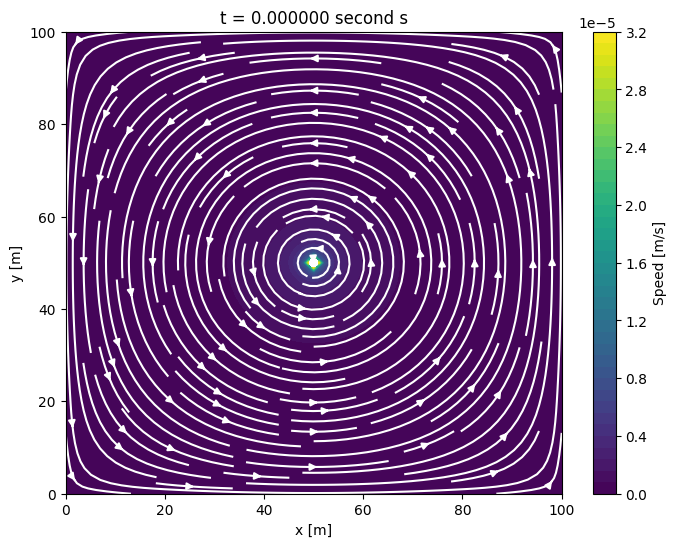

  0%|          | 10/10000 [00:53<14:39:17,  5.28s/it]

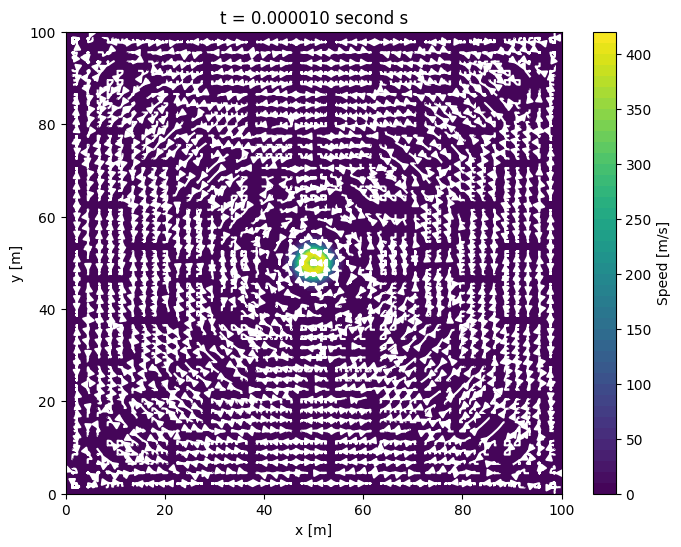

  0%|          | 20/10000 [01:53<15:02:29,  5.43s/it]

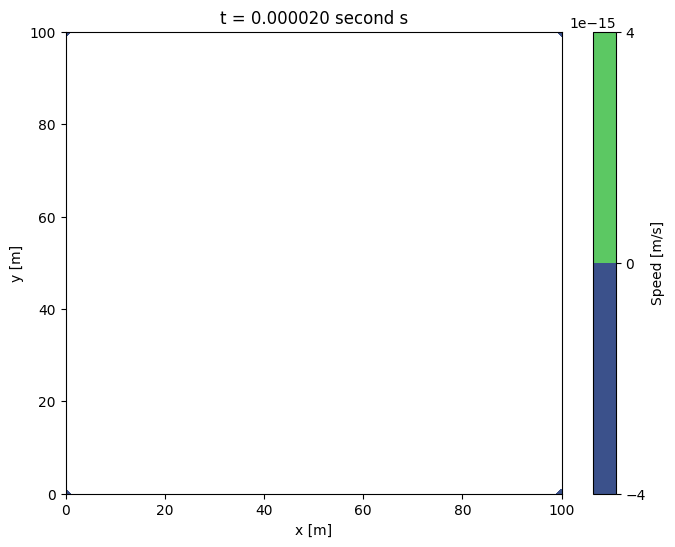

  0%|          | 23/10000 [02:10<15:42:06,  5.67s/it]


KeyboardInterrupt: 

In [15]:
for n in tqdm(range(num_steps)):
    t = n * dt
    
    omega = update_vorticity(omega, u, v, nu_m2_s, dx_m, dy_m, dt_s)
    # print("update_vorticity")
    omega = apply_vorticity_boundary_conditions(omega, psi, dx_m, dy_m)
    # print("apply_vorticity_boundary_conditions")
    psi = apply_psi_boundary_conditions(psi)
    # print("apply_psi_boundary_conditions")
    psi = solve_poisson(psi, omega, dx_m, dy_m)
    # print("solve_poisson")
    u, v = get_velocities(psi, dx_m, dy_m)
    # print("get_velocities")

    # Plot every 10 steps
    if n % 10 == 0:
        X, Y = jnp.meshgrid(x, y, indexing='ij')
        speed = jnp.sqrt(u**2 + v**2)
        
        # Convert JAX arrays to NumPy
        X_np = np.asarray(X)
        Y_np = np.asarray(Y)
        speed_np = np.asarray(speed)
        u_np = np.asarray(u)
        v_np = np.asarray(v)
        
        plt.figure(figsize=(8, 6))
        plt.contourf(X_np, Y_np, speed_np, levels=50, cmap='viridis')
        plt.colorbar(label='Speed [m/s]')
        plt.streamplot(X_np.T, Y_np.T, u_np.T, v_np.T, color='white', density=1.5)
        plt.title(f't = {t:.6f} s')
        plt.xlabel('x [microns]')
        plt.ylabel('y [microns]')
        plt.show()